# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from matplotlib import pyplot as plt

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

ModuleNotFoundError: No module named 'bs4'

In [6]:
from utils import utils

[nltk_data] Downloading package punkt to /home/lasse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define filepaths

In [2]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing data, which has been extracted manually, but entered by a machine
data_sources_raw_manual_machine = cwd / 'data_in' / 'data_raw_manually_extracted' / 'machine_entered'
data_sources_raw_manual_machine.mkdir(parents=True, exist_ok=True)

# Folder containing data, which has been extracted manually, and entered by a human
data_sources_raw_manual_human = cwd / 'data_in' / 'data_raw_manually_extracted' / 'human_entered'
data_sources_raw_manual_human.mkdir(parents=True, exist_ok=True)

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

# Folder to export validation results
validation_and_analysis = cwd / 'data_out' / 'data_validation'
validation_and_analysis.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [3]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping_sdmx_encoding.py') as file:
    exec(file.read())

## Read data dictionary

In [8]:
# sources sheet
crba_data_dictionary_source = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Source",
    keep_default_na = False
)
# Delete sources that are deprecated
crba_data_dictionary_source = crba_data_dictionary_source[crba_data_dictionary_source.STATUS != 'Deleted']

# snapshot sheet
crba_data_dictionary_snapshot = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Snapshot",
    keep_default_na = False
)

# Delete snapshots which aren't used in 2020
crba_data_dictionary_snapshot = crba_data_dictionary_snapshot[crba_data_dictionary_snapshot.YEAR_USED == 2020]

# indicator sheet
crba_data_dictionary_indicator = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Indicator",
    keep_default_na = False,
)

    # Delete indicators that are deprecated
crba_data_dictionary_indicator = crba_data_dictionary_indicator[crba_data_dictionary_indicator.STATUS != 'Deleted']

    # Pandas also reads rows with no content (empty strings)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.loc[crba_data_dictionary_indicator.INDICATOR_NAME != '', :]


# Input lists
crba_data_dictionary_input_list = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Input_Lists",
    keep_default_na = False
)


In [9]:
crba_data_dictionary_indicator

INDICATOR_ID PROJECT                      INDEX  \
0            I-1    CRBA                  Workplace   
1            I-2    CRBA                  Workplace   
2            I-3    CRBA                  Workplace   
3            I-4    CRBA                  Workplace   
4            I-5    CRBA                  Workplace   
..           ...     ...                        ...   
215        I-216    CRBA                Marketplace   
216        I-217    CRBA  Community and Environment   
217        I-218    CRBA                  Workplace   
218        I-219    CRBA                  Workplace   
219        I-220    CRBA                  Workplace   

                                  ISSUE                       CATEGORY  \
0                          Child labour  Legal framework international   
1                          Child labour  Legal framework international   
2                          Child labour  Legal framework international   
3                          Child labour  Legal framework international   
4                          Child labour  Legal framework international   
..                                  ...                            ...   
215       Online Abuse and exploitation                        Outcome   
216                   Natural disasters                        Outcome   
217           Decent working conditions       Legal framework national   
218           Decent working conditions       Legal framework national   
219  Maternity and paternity protection                    Enforcement   

    INDICATOR_CODE_2018                                     INDICATOR_NAME  \
0               1.1.1.1                             Minimum Age Convention   
1               1.1.3.1             Worst Forms of Child Labour Convention   
2               1.1.2.1  Optional Protocol to CRC on the Sale of Childr...   
3               1.1.2.4  UN Protocol to Prevent, Suppress and Punish Tr...   
4               1.1.2.5                           Forced Labour Convention   
..                  ...                                                ...   
215                 NEW   Child sexual abuse and exploitation. Engagement.   
216               3.3.3  Number of people internally displaced by natur...   
217                 NEW                                        Weekly rest   
218                 NEW                         Wage premium for nightwork   
219                 NEW                    Quality of pre-primary teaching   

                                 INDICATOR_DESCRIPTION  \
0    Ratification of ILO convention No. 138. Minimu...   
1    Ratification of ILO convention No. 182. Worst ...   
2    Ratification of Optional Protocol to the Conve...   
3    Ratification of UN Protocol to Prevent, Suppre...   
4    Ratification of ILO Convention No. 29. Forced ...   
..                                                 ...   
215  Degree of engagement of industry, civil societ...   
216  Number of internally displaced persons (IDPs) ...   
217       Are workers guaranteed a weekly day of rest?   
218            Is there a wage premium for night work?   
219  Trained teachers in preprimary education (% of...   

                                 INDICATOR_EXPLANATION   STATUS  ... CURRENT  \
0    This indicator assesses whether a country has ...  Created  ...       1   
1    This indicator assesses whether a country has ...  Created  ...       1   
2    This indicator assesses whether a country has ...  Created  ...       1   
3    This indicator assesses whether a country has ...  Created  ...       1   
4    This indicator assesses whether a country has ...  Created  ...       1   
..                                                 ...      ...  ...     ...   
215                                                     Created  ...       1   
216                                                     Created  ...       1   
217                                                     Created  ...       1   
218                 

In [10]:
crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
)

INDICATOR_ID PROJECT                      INDEX  \
0            I-1    CRBA                  Workplace   
1            I-2    CRBA                  Workplace   
2            I-3    CRBA                  Workplace   
3            I-4    CRBA                  Workplace   
4            I-5    CRBA                  Workplace   
..           ...     ...                        ...   
201        I-211    CRBA  Community and Environment   
202        I-212    CRBA  Community and Environment   
203        I-213    CRBA  Community and Environment   
204        I-214    CRBA  Community and Environment   
205        I-217    CRBA  Community and Environment   

                                          ISSUE  \
0                                  Child labour   
1                                  Child labour   
2                                  Child labour   
3                                  Child labour   
4                                  Child labour   
..                                          ...   
201  Resource use and damage to the environment   
202  Resource use and damage to the environment   
203                       Security arrangements   
204                           Natural disasters   
205                           Natural disasters   

                          CATEGORY INDICATOR_CODE_2018  \
0    Legal framework international             1.1.1.1   
1    Legal framework international             1.1.3.1   
2    Legal framework international             1.1.2.1   
3    Legal framework international             1.1.2.4   
4    Legal framework international             1.1.2.5   
..                             ...                 ...   
201                    Enforcement                 ADD   
202                    Enforcement                 ADD   
203                    Enforcement                 ADD   
204                    Enforcement                 ADD   
205                        Outcome               3.3.3   

                                        INDICATOR_NAME  \
0                               Minimum Age Convention   
1               Worst Forms of Child Labour Convention   
2    Optional Protocol to CRC on the Sale of Childr...   
3    UN Protocol to Prevent, Suppress and Punish Tr...   
4                             Forced Labour Convention   
..                                                 ...   
201  Reporting on hazardous waste commitments (Base...   
202  Reporting on hazardous waste commitments (Stoc...   
203        Political Stability and Absence of Violence   
204    National strategy aligned with Sendai Framework   
205  Number of people internally displaced by natur...   

                                 INDICATOR_DESCRIPTION  \
0    Ratification of ILO convention No. 138. Minimu...   
1    Ratification of ILO convention No. 182. Worst ...   
2    Ratification of Optional Protocol to the Conve...   
3    Ratification of UN Protocol to Prevent, Suppre...   
4    Ratification of ILO Convention No. 29. Forced ...   
..                                                 ...   
201  Parties meeting their commitments and obligati...   
202  Reporting on hazardous waste commitments. Part...   
203  Perceptions of the likelihood of political ins...   
204  Number of countries that reported having a Nat...   
205  Number of internally displaced persons (IDPs) ...   

                                 INDICATOR_EXPLANATION   STATUS  ...  \
0    This indicator assesses whether a country has ...  Created  ...   
1    This indicator assesses whether a country has ...  Created  ...   
2    This indicator assesses whether a country has ...  Created  ...   
3    This indicator assesses whether a country has ...  Created  ...   
4    This indicator assesses whether a country has ...  Created  ...   
..                                                 ...      ...  ...   
201  indicator of implementation of conventions on ...  Created  ...   
202  indicator of implementation of conventions on ...  Created

In [ ]:

# Add 2-digit shortcodes of index, issue and category to indicators sheet
crba_data_dictionary_indicator = crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
).merge(
    right=crba_data_dictionary_input_list[['ISSUE', 'ISSUE_CODE']],
    left_on='ISSUE',
    right_on='ISSUE'
).merge(
    right=crba_data_dictionary_input_list[['CATEGORY', 'CATEGORY_CODE']],
    left_on='CATEGORY',
    right_on='CATEGORY'
)

# Create indicator code prefix (INDEX-ISSUE_CAEGORY CODE)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE_PREFIX = crba_data_dictionary_indicator.INDEX_CODE +
    "_" +
    crba_data_dictionary_indicator.ISSUE_CODE+
    "_"+
    crba_data_dictionary_indicator.CATEGORY_CODE+
    "_")

# Create indicator code
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE = crba_data_dictionary_indicator.INDICATOR_CODE_PREFIX + crba_data_dictionary_indicator.INDICATOR_NAME.apply(
    lambda x: utils.create_ind_code(x)
))

# Check if there are indicators which have been assigned the same indicator code: 
duplicate_codes = crba_data_dictionary_indicator[crba_data_dictionary_indicator.duplicated(subset = 'INDICATOR_CODE', keep = False)][['INDICATOR_CODE', 'INDICATOR_ID']]

if len(duplicate_codes) != 0:
    raise Exception(f"WARNING: Theese are indicator names that have been assigned with the same indicator code {duplicate_codes} \n Please change the names to avoid duplicates")
else:
    print("No duplicate indicator codes present. You can proceed.")

The following code snippet is only temporary, as long as the selenium webdriver is not running in the docker container yet. This concerns the ILO NORMLEX indicators

The workaround for this is to open the file in a virtual env and run the code there. 

In [ ]:
# TEMP, TO DO: Delete this snippet again
ilo_normlex_data_dictionar_spex = crba_data_dictionary_source[crba_data_dictionary_source.SOURCE_BODY == 'ILO NORMLEX'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

ilo_normlex_data_dictionar_spex.to_csv(
    data_in / 'temp_ilo_normlex_data_dictionar_spex.csv',
    sep=';'
)

# Staging (pre-processing) to create exceptional indicators´ raw data 

#

In [ ]:
# Pre-processing of exceptional indicators, which require extra transformation
# Important: File requires having filepaths from above defined and pandas already imported
with open(data_in / 'staging_create_raw_data_machine_entered.py') as file:
    exec(file.read())

with open(data_in / 'staging_create_raw_data_human_entered.py') as file:
    exec(file.read())

TypeError: expected <class 'openpyxl.styles.fills.Fill'>

# Extract - Transform - Load Loops
## API sources
### CSV API sources

In [ ]:
import logging
logging.basicConfig(filename='tmp/myapp.log', level=logging.DEBUG, 
                    format='%(asctime)s %(levelname)s %(name)s %(message)s')
logger=logging.getLogger(__name__)
# CSV sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (NRGI)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define epmty dataframe; not necessary if previously defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    try:
        print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
        
        # Extraction section
        dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
        
        # Save raw data
        dataframe.to_csv(
            data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
            sep = ";"
            )
        
        print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
        
        
        # Log that we are entering cleasning
        print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
        
        # Cleansing
        dataframe = cleanse.Cleanser().extract_who_raw_data(
            raw_data=dataframe,
            variable_type = row["VALUE_LABELS"],
            display_value_col="Display Value"
        )
        
        #print(dataframe)
        # Exception: S-126 is a UNICEF API source, but has a different structure (repetitive columns) --> rename them so they are being included in the rename_and_discard_columns function
        if row["SOURCE_ID"] == 'S-126':
            dataframe = dataframe.rename(
                columns = {
                    'Geographic area' : 'Geographic area_unused',
                    'Sex' : 'Sex_unused',
                    'AGE' : 'AGE_unused'
                }
            )
        else:
            pass

        dataframe = cleanse.Cleanser().rename_and_discard_columns(
            raw_data=dataframe,
            mapping_dictionary=mapping_dict,
            final_sdmx_col_list=sdmx_df_columns_all
        )

        # Specific to data from API (NRGI) --> Only two sources
        if row["SOURCE_TYPE"] == "API (NRGI)":
            dataframe['RAW_OBS_VALUE'] = dataframe['RAW_OBS_VALUE'].apply(
                lambda x: np.nan if x == '.' else x
            )

        dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
            dataframe=dataframe,
            year_col="TIME_PERIOD",
            time_cov_col="COVERAGE_TIME"
        )

        dataframe = cleanse.Cleanser().retrieve_latest_observation(
            renamed_data=dataframe,
            dim_cols = sdmx_df_columns_dims,
            country_cols = sdmx_df_columns_country,
            time_cols = sdmx_df_columns_time,
            attr_cols=sdmx_df_columns_attr,
        )
        
        dataframe = cleanse.Cleanser().add_and_discard_countries(
            grouped_data=dataframe,
            crba_country_list=country_crba_list,
            country_list_full = country_full_list
        )

        dataframe = cleanse.Cleanser().add_cols_fill_cells(
            grouped_data_iso_filt=dataframe,
            dim_cols=sdmx_df_columns_dims,
            time_cols=sdmx_df_columns_time,
            indicator_name_string=row["INDICATOR_NAME_y"],
            index_name_string=row["INDEX"],
            issue_name_string=row["ISSUE"],
            category_name_string=row["CATEGORY"],
            indicator_code_string=row["INDICATOR_CODE"],
            indicator_source_string=row["ADDRESS"],
            indicator_source_body_string=row["SOURCE_BODY"],
            indicator_description_string=row["INDICATOR_DESCRIPTION"],
            indicator_explanation_string=row["INDICATOR_EXPLANATION"],
            indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
            source_title_string=row["SOURCE_TITLE"],
            source_api_link_string=row["ENDPOINT_URL"],
            attribute_unit_string=row["UNIT_MEASURE"]
        )

        dataframe = cleanse.Cleanser().map_values(
            cleansed_data = dataframe,
            value_mapping_dict = value_mapper
        )
        
        dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
            dataframe = dataframe,
            encoding_string = row["VALUE_ENCODING"],
            encoding_labels = row["VALUE_LABELS"]
        )

        dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
            cleansed_data=dataframe_cleansed
        )

        # Append dataframe to combined dataframe
        combined_cleansed_csv = combined_cleansed_csv.append(
            other = dataframe_cleansed
        )

        # Save cleansed data
        dataframe_cleansed.to_csv(
            data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
            sep = ";")
        
        # Normalizing
        dataframe_normalized = scaler.normalizer(
            cleansed_data = dataframe_cleansed,
            sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
            # dim_cols=sdmx_df_columns_dims,
            variable_type = row["VALUE_LABELS"],
            is_inverted = row["INVERT_NORMALIZATION"],
            whisker_factor=1.5,
            raw_data_col="RAW_OBS_VALUE",
            scaled_data_col_name="SCALED_OBS_VALUE",
            maximum_score=10,
            )
        
        dataframe_normalized.to_csv(
            data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
            sep = ";")

        # Append dataframe to combined dataframe
        combined_normalized_csv = combined_normalized_csv.append(
            other = dataframe_normalized
        )
    except Exception as e:
        logger.error(msg=f"{row['SOURCE_ID']}",exc_info=True)


 - - - - - 
 Extracting source S-50 

HTTP error occurred: 404 Client Error: Not Found for url: https://www.ilo.org/sdmx/rest/data/ILO,DF_YI_ALL_EAR_GGAP_OCU_RT/?format=csv&startPeriod=2010-01-01&endPeriod=2020-12-31
The following columns are present in the datasets, and this is the number of unique values they have. 
The column Could not find Dataflow and/or DSD related with this data request has 0 unique values.
There was a problem with extraction of source S-50 


 - - - - - 
 Cleansing source S-50 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 - - - - - 
 Extracting source S-51 

HTTP error occurred: 404 Client Error: Not Found for url: https://www.ilo.org/sdmx/rest/data/ILO,DF_YI_ALL_HOW_UEMP_SEX_NB/?format=csv&startPeriod=2010-01-01&endPeriod=2020-12-31
The following columns are present in the datasets, and this is the number of unique values they have. 
The column Could not

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(



 - - - - - 
 Extracting source S-53 

HTTP error occurred: 404 Client Error: Not Found for url: https://www.ilo.org/sdmx/rest/data/ILO,DF_SDG_ALL_SDG_0552_OCU_RT/?format=csv&startPeriod=2010-01-01&endPeriod=2020-12-31
The following columns are present in the datasets, and this is the number of unique values they have. 
The column Could not find Dataflow and/or DSD related with this data request has 0 unique values.
There was a problem with extraction of source S-53 


 - - - - - 
 Cleansing source S-53 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 - - - - - 
 Extracting source S-55 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Dataflow has 1 unique values.
The column STAT_UNIT has 1 unique values.
The column UNIT_MEASURE has 1 unique values.
The column EDU_LEVEL has 1 unique values.
The column EDU_CAT has 1 uni

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column Dataflow has 1 unique values.
The column STAT_UNIT has 1 unique values.
The column UNIT_MEASURE has 1 unique values.
The column EDU_LEVEL has 1 unique values.
The column EDU_CAT has 1 unique values.
The column SEX has 3 unique values.
The column AGE has 1 unique values.
The column GRADE has 1 unique values.
The column SECTOR_EDU has 1 unique values.
The column EDU_ATTAIN has 1 unique values.
The column SUBJECT has 1 unique values.
The column WEALTH_QUINTILE has 1 unique values.
The column INFRASTR has 1 unique values.
The column LOCATION has 1 unique values.
The column EDU_TYPE has 1 unique values.
The column SE_BKGRD has 1 unique values.
The column SOURCE_FUND has 1 unique values.
The column FUND_FLOW has 1 unique values.
The column IMM_STATUS has 1 unique values.
The column REF_AREA has 264 unique values.
The column TIME_PERIOD has 2 unique values.
The column OBS_VALUE ha

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(



 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-82 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 132 unique values.
The column Display Value has 3 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-82 


 - - - - - 
 Cleansing source S-82 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 TIME_PERIOD column contained time periods (no atomic years). Successfully extrated year. 

 Calling functi

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 132 unique values.
The column Display Value has 3 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-82 


 - - - - - 
 Cleansing source S-82 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 TIME_PERIOD column contained time periods (no atomic years). Successfully extrated year. 

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 132 unique values.
The column Display Value has 4 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-83 


 - - - - - 
 Cleansing source S-83 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 TIME_PERIOD column contained time periods (no atomic years). Successfully extrated year. 

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 132 unique values.
The column Display Value has 4 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-83 


 - - - - - 
 Cleansing source S-83 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 TIME_PERIOD column contained time periods (no atomic years). Successfully extrated year. 

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 4 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column Display Value has 6 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 5 unique values.
There was a problem with extraction of source S-88 


 - - - - - 
 Cleansing source S-88 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 8 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 195 unique values.
The column Display Value has 4 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-90 


 - - - - - 
 Cleansing source S-90 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 8 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 195 unique values.
The column Display Value has 4 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-91 


 - - - - - 
 Cleansing source S-91 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column ALCOHOLTYPE has 3 unique values.
The column Display Value has 16 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-92 


 - - - - - 
 Cleansing source S-92 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 2 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column ADVERTISINGTYPE has 3 unique values.
The column Display Value has 11 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-93 


 - - - - - 
 Cleansing source S-93 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column Display Value has 3 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-95 


 - - - - - 
 Cleansing source S-95 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 135 unique values.
The column SEX has 3 unique values.
The column Display Value has 223 unique values.
The column Numeric has 223 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-97 


 - - - - - 
 Cleansing source S-97 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cell

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column DATASOURCE has 70 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 15 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 70 unique values.
The column SEX has 3 unique values.
The column Display Value has 215 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-100 


 - - - - - 
 Cleansing source S-100 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countrie

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column Display Value has 0 unique values.
The column Numeric has 0 unique values.
The column Low has 0 unique values.
The column High has 0 unique values.
The column StdErr has 0 unique values.
The column StdDev has 0 unique values.
The column Comments has 0 unique values.
There was a problem with extraction of source S-101 


 - - - - - 
 Cleansing source S-101 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 - - - - - 
 Extracting source S-103 

HTTP error occurred: 502 Server Error: Bad Gateway for url: https://apps.who.int/gho/athena/api/GHO/NCD_BMI_PLUS1C.csv

 - - - - - 
 Extracting source S-104 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column DATASOURCE has 7 unique valu

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column DATASOURCE has 7 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 35 unique values.
The column REGION has 8 unique values.
The column WORLDBANKINCOMEGROUP has 6 unique values.
The column COUNTRY has 136 unique values.
The column Display Value has 579 unique values.
The column Numeric has 557 unique values.
The column Low has 292 unique values.
The column High has 301 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 608 unique values.
There was a problem with extraction of source S-104 


 - - - - - 
 Cleansing source S-104 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 20 unique values.
The column REGION has 8 unique values.
The column WORLDBANKINCOMEGROUP has 6 unique values.
The column COUNTRY has 184 unique values.
The column SEX has 3 unique values.
The column Display Value has 2516 unique values.
The column Numeric has 11339 unique values.
The column Low has 11116 unique values.
The column High has 11431 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-113 


 - - - - - 
 Cleansing source S-113 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'a

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(



 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-126 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column REF_AREA has 151 unique values.
The column Geographic area has 151 unique values.
The column INDICATOR has 1 unique values.
The column Indicator has 1 unique values.
The column SEX has 3 unique values.
The column Sex has 3 unique values.
The column AGE has 3 unique values.
The column Current age has 3 unique values.
The column EDUCATION_LEVEL has 1 unique values.
The column Education Level has 1 unique values.
The column WEALTH_QUINTILE has 1 unique values.
The column Wealth Quintile has 1 unique values.
The column RESIDENCE has 1 unique values.
The column Residence has 1 unique values.
The column NUMBER_CHLD has 1 unique values.
The column Number of Living Children has 1 unique values.
The column UNIT_MULTIPLIER has 1 unique values.
The column Unit multiplier has 1 unique values.
The column UNIT_MEASU

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 5 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column Display Value has 6 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 6 unique values.
There was a problem with extraction of source S-135 


 - - - - - 
 Cleansing source S-135 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'.

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 5 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column Display Value has 6 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 6 unique values.
There was a problem with extraction of source S-136 


 - - - - - 
 Cleansing source S-136 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'.

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 5 unique values.
The column REGION has 7 unique values.
The column COUNTRY has 194 unique values.
The column Display Value has 6 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 6 unique values.
There was a problem with extraction of source S-137 


 - - - - - 
 Cleansing source S-137 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'.

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


HTTP error occurred: 404 Client Error: Not Found for url: https://api.resourcegovernanceindex.org/system/documents/documents/000/000/141/original/2017ResourceGovernanceIndex.csv?1518782068

 - - - - - 
 Extracting source S-156 

HTTP error occurred: 404 Client Error: Not Found for url: https://api.resourcegovernanceindex.org/system/documents/documents/000/000/141/original/2017ResourceGovernanceIndex.csv?1518782068

 - - - - - 
 Extracting source S-157 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 183 unique values.
The column SEX has 3 unique values.
The column ENVCAUSE has 1 unique values.
The column Display Value has 355 unique values.
The column Numeric has 548 unique values.
The column Low has 526 unique values.
The column High has 547 unique valu

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 10 unique values.
The column REGION has 8 unique values.
The column UNREGION has 9 unique values.
The column WHOINCOMEREGION has 12 unique values.
The column COUNTRY has 196 unique values.
The column RESIDENCEAREATYPE has 5 unique values.
The column Display Value has 10418 unique values.
The column Numeric has 10404 unique values.
The column Low has 10403 unique values.
The column High has 10406 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-158 


 - - - - - 
 Cleansing source S-158 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'r

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(



 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-199 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 20 unique values.
The column REGION has 7 unique values.
The column WORLDBANKINCOMEGROUP has 5 unique values.
The column COUNTRY has 193 unique values.
The column Display Value has 3934 unique values.
The column Numeric has 3934 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-199 


 - - - - - 
 Cleansing source S-199 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observati

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


HTTP error occurred: 404 Client Error: Not Found for url: https://www.ilo.org/sdmx/rest/data/ILO,DF_IR_ALL_ILR_TUMT_NOC_RT/?format=csv&startPeriod=2010-01-01&endPeriod=2020-12-31
The following columns are present in the datasets, and this is the number of unique values they have. 
The column Could not find Dataflow and/or DSD related with this data request has 0 unique values.
There was a problem with extraction of source S-205 


 - - - - - 
 Cleansing source S-205 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 - - - - - 
 Extracting source S-207 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column ALCOHOLTYPE has 3 unique 

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column Dataflow has 1 unique values.
The column STAT_UNIT has 1 unique values.
The column UNIT_MEASURE has 1 unique values.
The column EDU_LEVEL has 1 unique values.
The column EDU_CAT has 1 unique values.
The column SEX has 3 unique values.
The column AGE has 1 unique values.
The column GRADE has 1 unique values.
The column SECTOR_EDU has 1 unique values.
The column EDU_ATTAIN has 1 unique values.
The column SUBJECT has 1 unique values.
The column WEALTH_QUINTILE has 1 unique values.
The column INFRASTR has 1 unique values.
The column LOCATION has 1 unique values.
The column EDU_TYPE has 1 unique values.
The column SE_BKGRD has 1 unique values.
The column SOURCE_FUND has 1 unique values.
The column FUND_FLOW has 1 unique values.
The column IMM_STATUS has 1 unique values.
The column REF_AREA has 283 unique values.
The column TIME_PERIOD has 2 unique values.
The column OBS_VALUE ha

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column ADVERTISINGTYPE has 3 unique values.
The column Display Value has 11 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-209 


 - - - - - 
 Cleansing source S-209 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_col

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 194 unique values.
The column ADVERTISINGTYPE has 3 unique values.
The column Display Value has 12 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column StdErr has 1 unique values.
The column StdDev has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-210 


 - - - - - 
 Cleansing source S-210 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_col

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/home/lasse/Development/crba-etl/normalize/scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


HTTP error occurred: 404 Client Error: Not Found for url: https://www.ilo.org/sdmx/rest/data/ILO,DF_IR_ALL_ILR_CBCT_NOC_RT/?format=csv&startPeriod=2010-01-01&endPeriod=2020-12-31
The following columns are present in the datasets, and this is the number of unique values they have. 
The column Could not find Dataflow and/or DSD related with this data request has 0 unique values.
There was a problem with extraction of source S-211 


 - - - - - 
 Cleansing source S-211 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 - - - - - 
 Extracting source S-215 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column DATAFLOW has 1 unique values.
The column REF_AREA:Country has 206 unique values.
The column INDICATOR:Indicator has 1 unique values.
The column SEX:Sex has 3 unique values.
The column AGE:Current age has 1 unique values.
The

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(



 - - - - - 
 Extracting source S-221 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column DATAFLOW has 1 unique values.
The column CDDDEMINDICS:Demographic indicators has 1 unique values.
The column CDUNIT:Unit has 1 unique values.
The column CDAREAS:Areas has 68 unique values.
The column CDGENDER:Sex has 1 unique values.
The column CDAGE:Age groups has 3 unique values.
The column CDDEMOSTRATIFIERS:Other stratifiers has 15 unique values.
The column TIME_PERIOD:Time period has 16 unique values.
The column OBS_VALUE:Observation Value has 38686 unique values.
The column CDDATASOURCE:Data source has 1 unique values.
The column TIME_FORMAT:Time Format has 1 unique values.
There was a problem with extraction of source S-221 


 - - - - - 
 Cleansing source S-221 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...
The column COUNTRY_ISO_3 is of a different data structure. This should 

/tmp/ipykernel_20621/3020032462.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_cleansed_csv = combined_cleansed_csv.append(
/tmp/ipykernel_20621/3020032462.py:167: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_normalized_csv = combined_normalized_csv.append(


### JSON API sources

In [ ]:
# JSON sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (SDG)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WB)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.JSONExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing in 
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().convert_nan_strings_into_nan(
        dataframe = dataframe
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"],
        na_encodings = row["NA_ENCODING"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-23 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 1 unique values.
The column target has 1 unique values.
The column indicator has 1 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 86 unique values.
The column geoAreaName has 86 unique values.
The column timePeriodStart has 20 unique values.
The column value has 3190 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 51 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 17 unique values.
The column attributes.Nature has 2 unique

## HTML Sources
### UN Treaty Sources

In [ ]:
# UN Treaty HTML sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "UN Treaties")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.HTMLExtractor().extract(url = row["ADDRESS"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")

    # Cleansing
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-3 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Participant has 185 unique values.
The column Signature has 59 unique values.
The column Ratification, Accession(a), Succession(d) has 173 unique values.

 - - - - - 
 Cleansing source S-3 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-4 

The following colum

### ILO NORMLEX sources

This code snippet it only a temporary work around to make algoruthm work. It sould be deleted 

In [ ]:
""" #Uncomment this, as soon as selenium webdriver is working in docker
# ILO Normlex sources
ilo_normlex_sources = crba_data_dictionary_source[crba_data_dictionary_source.SOURCE_BODY == 'ILO NORMLEX'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)
"""

"""
# Delete the following, as soon as selenium is working in docker until comment flat "stop delete"
ilo_normlex_sources = pd.read_csv(
    data_in / 'temp_ilo_normlex_data_dictionar_spex.csv',
    sep = ';',
    keep_default_na=False
)
# Flag "Stop delete" 

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
# ilo_normlex_sources = ilo_normlex_sources[
# (ilo_normlex_sources["SOURCE_ID"] != 'S-1')]# & 
#(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
#(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-21')] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Define parameters required for Selenium to work (can't use Posix path with selenium)
# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)
    
# Loop to extract data from API sources
for index, row in ilo_normlex_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))

    # request
    print(row["ADDRESS"])
    response = driver.get(row["ADDRESS"])

    # Soupify the actual html content from response
    soup = bs.BeautifulSoup(driver.page_source)

    # Extract the target table as attribute
    target_table = str(
        soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
    )

    # Create dataframe with the data
    raw_data = pd.read_html(io=target_table, header=0)[
        0
    ]# return is a list of DFs, specify [0] to get actual DF

    # Save raw data (as actual raw, rather than staged raw data)
    raw_data.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )

    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=raw_data,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
        dataframe = dataframe,
        country_name_list = country_full_list["COUNTRY_NAME"]
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"], #row["SOURCE_ID"], # TO DO: exchange this with row["INDICATOR_CODE"] in selenium  
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body='ILO NORMLEX'
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Create log info
    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )
"""

'\n# Delete the following, as soon as selenium is working in docker until comment flat "stop delete"\nilo_normlex_sources = pd.read_csv(\n    data_in / \'temp_ilo_normlex_data_dictionar_spex.csv\',\n    sep = \';\',\n    keep_default_na=False\n)\n# Flag "Stop delete" \n\n# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop \n# ilo_normlex_sources = ilo_normlex_sources[\n# (ilo_normlex_sources["SOURCE_ID"] != \'S-1\')]# & \n#(manually_extracted_sources["SOURCE_ID"] != \'S-169\') &\n#(manually_extracted_sources["SOURCE_ID"] != \'S-170\') #&\n#(manually_extracted_sources["SOURCE_ID"] == \'S-21\')] \n\n# define emty dataframe; not necessary if previous defined already\ntry:\n    combined_cleansed_csv\nexcept:\n    print("Dataframe cleansed was not defined yet. Now defining it.")\n    combined_cleansed_csv = pd.DataFrame()\ntry:\n    combined_normalized_csv\nexcept:\n    print("Dataframe normalized was not defined yet. N

## Manually extracted sources
### WPA sources

In [ ]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    #print(dataframe.head(30))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-8 


 Extracting data and store it as raw data
There was an issue with source S-8

 - - - - - 
 Cleansing source S-8 


 - - - - - 
 Cleansing source S-8 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_categorical_variables'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.000000
mean     2019.010256
std         0.101013
min      2019.000000
25%      2019.000000
50%      2019.000000
75%      2019.000000
max      2020.000000
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-9 


 Extracting data and store it as raw data
There was an issue with source S-9

 - - - - - 
 Cleansing source S-9 


 - - - - - 
 

### Manually extracted data (both human and machine-generated data) + data which required pre-processing
#### Normal ETL-pipeline


 - - - - - 
 Extracting source S-11 


 - - - - - 
 Cleansing source S-11 


 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...
Values of column: DIM_SEX couldn't be mapped. If column DIM_SEX is present, there is an error with the code. 
Values of column: DIM_EDU_LEVEL couldn't be mapped. If column DIM_EDU_LEVEL is present, there is an error with the code. 
Values of column: DIM_AGE_GROUP couldn't be mapped. If column DIM_AGE_GROUP is present, there is an error with the code. 
Values of column: DIM_MANAGEMENT_LEVEL couldn't be mapped. If column DIM_MANAGEMENT_LEVEL is present, there is an error with the code. 
Values of column: DIM_AREA_TYPE couldn't be mapped. If column DIM_AREA_TYPE is present, there is an error with the code. 
Values of column: DIM_QUAN

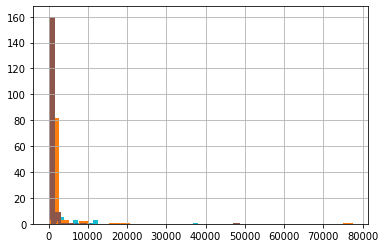

In [ ]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[
(manually_extracted_sources["SOURCE_ID"] != 'S-168') & 
(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
(manually_extracted_sources["SOURCE_ID"] != 'S-170') 
] 

#print(f"this is the dataframe: {manually_extracted_sources}")

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    """# Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )"""

    # print(dataframe)
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )
    
    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    #print(f"\n \n  the indicator name print is: \n {row['INDICATOR_NAME_x']} \n \n - - - - - - - - - - \n")

    #print(f"\n \n  the type is: \n {type(row['INDICATOR_NAME_x'])} \n \n - - - - - - - - - - \n")
    

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    #print(dataframe.RAW_OBS_VALUE.describe())

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info = True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

#### Treaty data pipeline

This pipeline is identical to HTML-Sources: UN Treaties data. It concerns sources S-168, S-169 and S-170

In [ ]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[(manually_extracted_sources["SOURCE_ID"] == 'S-168') | 
(manually_extracted_sources["SOURCE_ID"] == 'S-169') |
(manually_extracted_sources["SOURCE_ID"] == 'S-170') 
] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-168 


 - - - - - 
 Cleansing source S-168 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-169 


 - - - - - 
 Cleansing source S-169 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information 

## Concatenate all dataframes

In [ ]:
# define emty dataframe
combined_normalized_csv = pd.DataFrame()

# Iterate through all files
for file in data_sources_normalized.iterdir():
    try:
        print(file)
        dataframe = pd.read_csv(
                file,
                sep = ';'
            )

        # print(dataframe)

        dataframe['INTERNAL_SOURCE_ID'] = file
        
        combined_normalized_csv = combined_normalized_csv.append(
            other = dataframe
        )
    except:
        print('didnt read file')
        print(file)

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_normalized_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
combined_normalized_csv[available_dim_cols] = combined_normalized_csv[
    available_dim_cols
].fillna(value="_T")

# Double check if there are duplicate countries
print("This is the number of duplicate rows:")
print(sum(combined_normalized_csv.duplicated()))
#print(combined_normalized_csv.loc[combined_normalized_csv.duplicated(), ['COUNTRY_ISO_3','INDICATOR_NAME', 'INDICATOR_CODE']])
#combined_normalized_csv = combined_normalized_csv.drop_duplicates() # uncomment if want to delete duplicates (but check where they come from first)

# Check that all indicators have been processed
assert crba_data_dictionary_snapshot.shape[0] == len(combined_normalized_csv.INDICATOR_CODE.unique())

data_out/data_normalized/I-100_S-119_MP_OL_LF_ISRECS_normalized.csv
data_out/data_normalized/I-101_S-120_MP_OL_LF_CSAELF_normalized.csv
data_out/data_normalized/I-102_S-121_MP_OL_LF_ONEXAB_normalized.csv
data_out/data_normalized/I-103_S-122_MP_OL_LF_DAPRPR_normalized.csv
data_out/data_normalized/I-104_S-123_MP_OL_OC_RESMEC_normalized.csv
data_out/data_normalized/I-105_S-124_MP_OL_EN_CHSAEE_normalized.csv
data_out/data_normalized/I-106_S-125_MP_OL_OC_PRSEVI_normalized.csv
data_out/data_normalized/I-107_S-126_MP_OL_OC_FREBUL_normalized.csv
data_out/data_normalized/I-109_S-128_MP_OL_EN_ENECRF_normalized.csv
data_out/data_normalized/I-10_S-10_WP_CL_LF_COMSCH_normalized.csv
data_out/data_normalized/I-110_S-129_MP_MA_EN_GOVEFF_normalized.csv
data_out/data_normalized/I-111_S-130_MP_PS_EN_GOVCOR_normalized.csv
data_out/data_normalized/I-112_S-131_MP_OL_EN_EFJUSY_normalized.csv
data_out/data_normalized/I-114_S-134_MP_OL_EN_CSAEGC_normalized.csv
data_out/data_normalized/I-115_S-135_MP_MA_EN_OPPO

In [ ]:
# Export combined dataset
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

## Add aggregated scores

The following bit adds the aggregated scores to the final dataset. There are several approaches to creating aggregate scores.

The following implements the same aggregation methodology as for the CRBA 2018. That is, we introduce three aggregation levels: 

1. *Level 1:* Category-issue score (the average of all indicator scores pertaining to a given category and issue)
2. *Level 2:* Issue score (the average of all category-issue scores)
3. *Level 3:* Index score (the average of all issue scores in a given index)

This aggregation is done sequentelly as outlined above. 

Furthermore, a weighting is applied, to give more importance to outcome and enforcement indicators. This weighting is implemented by duplicating those level 1 category-issue scores of category "outcome" or "enforcement", before computing level 2 scores. 

In [ ]:
# Create category score
aggregated_scores_dataset = combined_normalized_csv.loc[
    combined_normalized_csv['COUNTRY_ISO_3'] != 'XKX', 
    [
        'COUNTRY_ISO_3',
        'SCALED_OBS_VALUE',
        'INDICATOR_INDEX',
        'INDICATOR_ISSUE',
        'INDICATOR_CATEGORY'
    ]
].groupby(
    by = [
        'COUNTRY_ISO_3',
        'INDICATOR_CATEGORY', 
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX'
    ],
    as_index = False
).mean().rename(
    columns={
        'SCALED_OBS_VALUE' : 'CATEGORY_ISSUE_SCORE'
    }
)

# # # # Introduce weighting: duplicate all index_issues who belong to category outcome or enforcement
aggregated_scores_dataset = aggregated_scores_dataset.append(
    aggregated_scores_dataset.loc[
        (aggregated_scores_dataset['INDICATOR_CATEGORY'] == 'Outcome') |
        (aggregated_scores_dataset['INDICATOR_CATEGORY'] == 'Enforcement')
    ]
)

# # # # # # # Issue score
temp = aggregated_scores_dataset.groupby(
    by = [
        'COUNTRY_ISO_3',
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX'
    ],
    as_index = False
).mean().rename(
    columns={
        'CATEGORY_ISSUE_SCORE' : 'ISSUE_INDEX_SCORE'
    }
)

# Drop duplicates again
temp = temp.drop_duplicates()

# # Add risk category
# Define list of percentiles
percentile_33 = temp[
    'ISSUE_INDEX_SCORE'
].quantile(
    0.333
)

percentile_66 = temp[
    'ISSUE_INDEX_SCORE'
].quantile(
    0.667
)

# Add column indicating risk category
temp.loc[
    temp['ISSUE_INDEX_SCORE'] < percentile_33,
    'ISSUE_INDEX_RISK_CATEGORY'
    ] = 'High risk' 

temp.loc[
    temp['ISSUE_INDEX_SCORE'] > percentile_66,
    'ISSUE_INDEX_RISK_CATEGORY'
    ] = 'Low risk'

temp.loc[
    (temp['ISSUE_INDEX_SCORE'] > percentile_33) & 
    (temp['ISSUE_INDEX_SCORE'] < percentile_66),
    'ISSUE_INDEX_RISK_CATEGORY'
    ] = 'Medium risk'



# # # # # #  Index score
temp_2 = temp.groupby(
    by = [
        'COUNTRY_ISO_3',
        'INDICATOR_INDEX'
    ],
    as_index = False
).mean().rename(
    columns={
        'ISSUE_INDEX_SCORE' : 'INDEX_SCORE'
    }
)

# # Add risk category
# Define list of percentiles
percentile_33 = temp_2[
    'INDEX_SCORE'
].quantile(
    0.333
)

percentile_66 = temp_2[
    'INDEX_SCORE'
].quantile(
    0.667
)

# Add column indicating risk category
temp_2.loc[
    temp_2['INDEX_SCORE'] < percentile_33,
    'INDEX_RISK_CATEGORY'
    ] = 'High risk' 

temp_2.loc[
    temp_2['INDEX_SCORE'] > percentile_66,
    'INDEX_RISK_CATEGORY'
    ] = 'Low risk'

temp_2.loc[
    (temp_2['INDEX_SCORE'] > percentile_33) & 
    (temp_2['INDEX_SCORE'] < percentile_66),
    'INDEX_RISK_CATEGORY'
    ] = 'Medium risk'





# # # # # Overall score
temp_3 = temp_2.groupby(
    by = [
        'COUNTRY_ISO_3',
    ],
    as_index = False
).mean().rename(
    columns={
        'INDEX_SCORE' : 'OVERALL_SCORE'
    }
)

# Join all aggregated score together
aggregated_scores_dataset = aggregated_scores_dataset.merge(
    right = temp,
    on = [
        'COUNTRY_ISO_3',
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX',
    ]
).merge(
    right = temp_2,
    on = [
        'COUNTRY_ISO_3',
        'INDICATOR_INDEX'
    ]
).merge(
    right = temp_3,
    on = [
        'COUNTRY_ISO_3',
    ]
).merge(
    right = country_crba_list,
    on = 'COUNTRY_ISO_3'
).drop(
    [
        'COUNTRY_NAME',
        'COUNTRY_ISO_2'
    ],
    axis=1
)

In [ ]:
# Join sores to original dataset
crba_final = combined_normalized_csv.merge(
    right=aggregated_scores_dataset,
    on=[
        'COUNTRY_ISO_3',
        'INDICATOR_CATEGORY',
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX'
    ],
    how='left' 
)

# Did not join on entire composite key on left, must drop dupliates
crba_final = crba_final.drop_duplicates()

### Export final, combined dataframe

In [ ]:
# Export combined cleansed dataframe as a sample
crba_final.to_csv(
    path_or_buf = cwd / 'data_out' / 'crba_final.csv',
    sep = ";",
    index=False
)
    
aggregated_scores_dataset.to_csv(
    path_or_buf = validation_and_analysis / 'aggregated_scores.csv',
    sep = ";"
)

## Postprocessing of final file to bring it into SDMX format

The file 'crba_final.csv' is comprehensive. It contains all relevant data, including metadata. Some of this information is superfluous and should not be inluded in the file to be uploaded in SDMX.

In [ ]:
# Read final dataframe
crba_final = pd.read_csv(
    cwd / 'data_out' / 'crba_final.csv',
    sep = ";"
)

# Discard unnecessary rows (i.e. in order to discard DIM_ELEMENT_TYPE limit ourselves to relevant subdimension group, then discard of column altogether)
crba_final = crba_final.loc[
    (crba_final['DIM_ELEMENT_TYPE'] == '_T') |
    (crba_final['DIM_ELEMENT_TYPE'] == '2017 RESOURCE GOVERNANCE INDEX')  
]

# Define list of columns to drop
dropped_cols = [
    'Unnamed: 0',
    '_merge',
    'COUNTRY_ISO_2',
    'COUNTRY_NAME',
    'DIM_REP_TYPE',
    'DIM_ELEMENT_TYPE',
    'ATTR_INDICATOR_DESCRIPTION', 
    'ATTR_INDICATOR_EXPLANATION', 
    'ATTR_DATA_EXTRACTION_METHDOLOGY', 
    'ATTR_SOURCE_TITLE', 
    'ATTR_SDG_INDICATOR_DESCRIPTION', 
    'ATTR_SOURCE_OF_SOURCE', 
    'ATTR_FOOTNOTE_OF_SOURCE',
    'INTERNAL_SOURCE_ID'
]

# Drop columns
crba_final_sdmx_ready = crba_final.drop(
    labels=dropped_cols,
    axis=1
) 

# Map values to encode them as SDMX codes 
# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping_sdmx_encoding.py') as file:
    exec(file.read())

crba_final_sdmx_ready = cleanse.Cleanser().map_values(
    cleansed_data = crba_final_sdmx_ready,
    value_mapping_dict = value_mapper_sdmx_encoding
)


# FSM has duplicate entry for four indicators (scoring was only done for one of them), drop rows that haven't been scored
sdmx_df_columns_dims = [
    "INDICATOR_CODE",
    "COUNTRY_ISO_3",
    "TIME_PERIOD",
    "DIM_SEX",
    "DIM_EDU_LEVEL",
    "DIM_AGE_GROUP",
    "DIM_MANAGEMENT_LEVEL",
    "DIM_AREA_TYPE",
    "DIM_QUANTILE",
    "DIM_SDG_INDICATOR",
    "DIM_OCU_TYPE",
    "DIM_SECTOR",
    "DIM_ALCOHOL_TYPE",
    "DIM_CAUSE_TYPE",
    "DIM_MATERNAL_EDU_LVL",
]

crba_final_sdmx_ready = crba_final_sdmx_ready.loc[~(crba_final_sdmx_ready.duplicated(
    subset = sdmx_df_columns_dims,
    keep=False
)) | ~(crba_final_sdmx_ready['SCALED_OBS_VALUE'].isna()), : ]

# Add dataflow column, TO DO: Adjust if necessary
crba_final_sdmx_ready['DATAFLOW'] = 'PFP:CRBA(1.0)'


 Calling function 'map_values'...

 Successfully mapped values of column: INDICATOR_INDEX

 Successfully mapped values of column: INDICATOR_ISSUE

 Successfully mapped values of column: INDICATOR_CATEGORY

 Successfully mapped values of column: DIM_AGE_GROUP

 Successfully mapped values of column: DIM_SEX

 Successfully mapped values of column: DIM_SECTOR

 Successfully mapped values of column: DIM_AREA_TYPE

 Successfully mapped values of column: DIM_EDU_LEVEL

 Successfully mapped values of column: DIM_MATERNAL_EDU_LVL

 Successfully mapped values of column: DIM_QUANTILE

 Successfully mapped values of column: DIM_OCU_TYPE

 Successfully mapped values of column: DIM_CAUSE_TYPE

 Successfully mapped values of column: DIM_MANAGEMENT_LEVEL


In [ ]:
# Save sdmx ready file
crba_final_sdmx_ready.to_csv(
    path_or_buf = cwd / 'data_out' / 'crba_final_sdmx_ready.csv',
    sep = ";",
    index=False
)

In [ ]:
print("End of file. \nCRBA successfully created/ updated.")

End of file. 
CRBA successfully created/ updated.


**End of file**